## Predictive Modelling on Telco Customer Churn

In [41]:
# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import joblib
from google.colab import files
import warnings
warnings.filterwarnings('ignore')

### Gather the data

In [16]:
# Read the source file from github and assign the sheet names as in excel file
url = 'https://github.com/Gouranga-GH/Additional-Files/raw/main/TCC_Data_PM/Telco_Customer_Churn_Data_Predictive_Modelling.xlsx'

In [17]:
# Get the sheet names
sheet_names = pd.ExcelFile(url).sheet_names
sheet_names

['vw_CS_Data', 'vw_J_Data']

In [18]:
# Read the dataframe from a sheet
df = pd.read_excel(url, engine='openpyxl', sheet_name=sheet_names[0])

In [19]:
# Check the dataframe
df.head()

,Customer_ID,Gender,Age,Married,State,Number_of_Referrals,Tenure_in_Months,Value_Deal,Phone_Service,Multiple_Lines,...,Payment_Method,Monthly_Charge,Total_Charges,Total_Refunds,Total_Extra_Data_Charges,Total_Long_Distance_Charges,Total_Revenue,Customer_Status,Churn_Category,Churn_Reason
0,11098-MAD,Female,30,Yes,Madhya Pradesh,0,31,Deal 1,Yes,No,...,Bank Withdrawal,95.099998,6683.399902,0.00,0,631.719971,7315.120117,Stayed,Others,Others
1,11114-PUN,Male,51,No,Punjab,5,9,Deal 5,Yes,No,...,Bank Withdrawal,49.150002,169.050003,0.00,10,122.370003,301.420013,Churned,Competitor,Competitor had better devices
2,11167-WES,Female,43,Yes,West Bengal,3,28,Deal 1,Yes,Yes,...,Bank Withdrawal,116.050003,8297.500000,42.57,110,1872.979980,10237.910156,Stayed,Others,Others
3,11179-MAH,Male,35,No,Maharashtra,10,12,NaN,Yes,No,...,Credit Card,84.400002,5969.299805,0.00,0,219.389999,6188.689941,Stayed,Others,Others
4,11180-TAM,Male,75,Yes,Tamil Nadu,12,27,Deal 2,Yes,No,...,Credit Card,72.599998,4084.350098,0.00,140,332.079987,4556.430176,Stayed,Others,Others


Pre-processing the data

In [20]:
# Create a copy
data = df.copy(deep=True)

In [21]:
# Drop columns that won't be used for prediction
data = data.drop(['Customer_ID', 'Churn_Category', 'Churn_Reason'], axis=1)

In [22]:
# List of columns to be label encoded
columns_to_encode = [
                      'Gender', 'Married', 'State', 'Value_Deal', 'Phone_Service', 'Multiple_Lines',
                      'Internet_Service', 'Internet_Type', 'Online_Security', 'Online_Backup',
                      'Device_Protection_Plan', 'Premium_Support', 'Streaming_TV', 'Streaming_Movies',
                      'Streaming_Music', 'Unlimited_Data', 'Contract', 'Paperless_Billing',
                      'Payment_Method'
                    ]

In [23]:
# Encode categorical variables except the target variable
label_encoders = {}
for column in columns_to_encode:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

In [24]:
# Manually encode the target variable 'Customer_Status'
data['Customer_Status'] = data['Customer_Status'].map({'Stayed': 0, 'Churned': 1})

In [25]:
# Split data into features and target
X = data.drop('Customer_Status', axis=1)
y = data['Customer_Status']

In [26]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

### ML Model Training and Evaluation

In [27]:
# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=101)
# Train the model
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=101)

In [28]:
# Make predictions
y_pred = rf_model.predict(X_test)

In [29]:
# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[813  43]
 [129 217]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       856
           1       0.83      0.63      0.72       346

    accuracy                           0.86      1202
   macro avg       0.85      0.79      0.81      1202
weighted avg       0.85      0.86      0.85      1202



In [30]:
# Feature Selection using Feature Importance
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

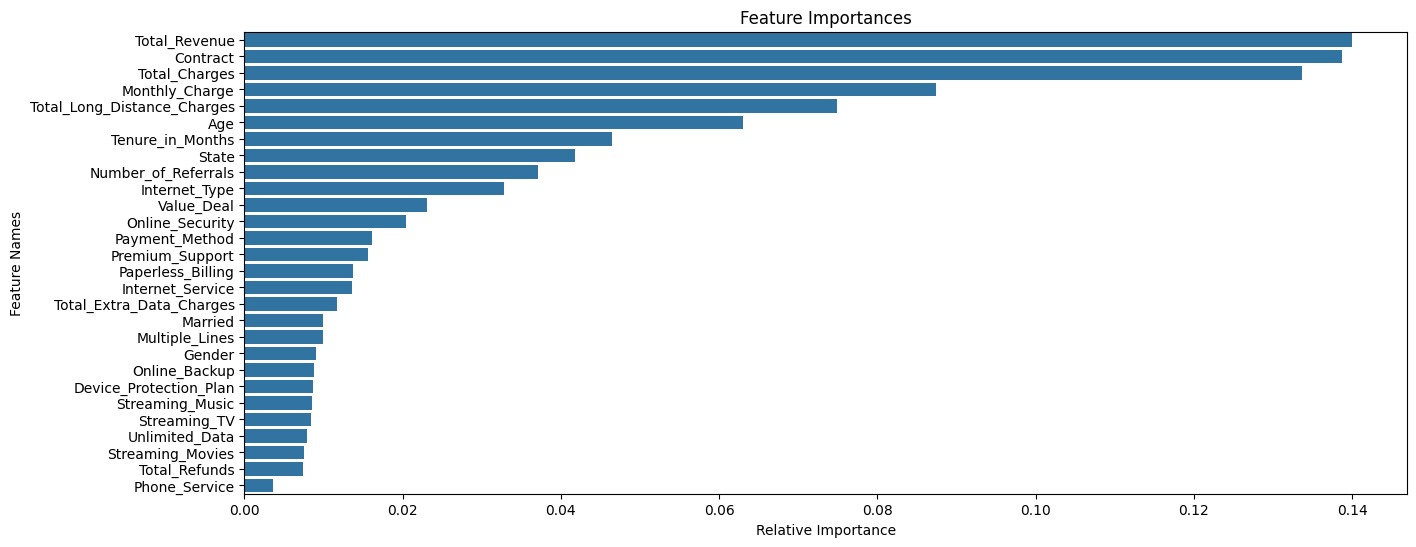

In [31]:
# Plot the feature importances
plt.figure(figsize=(15, 6))
sns.barplot(x=importances[indices], y=X.columns[indices])
plt.title('Feature Importances')
plt.xlabel('Relative Importance')
plt.ylabel('Feature Names')
plt.show()

### Model Prediction on New Data (Based on new joinees as customers)

In [32]:
 # Read the data from the specified sheet into a pandas DataFrame
new_data = pd.read_excel(url, engine='openpyxl', sheet_name=sheet_names[1])

In [34]:
 # Retain the original DataFrame to preserve unencoded columns
original_data = new_data.copy(deep=True)

In [35]:
# Retain the Customer_ID column
customer_ids = new_data['Customer_ID']

In [36]:
# Drop columns that won't be used for prediction in the encoded DataFrame
new_data = new_data.drop(['Customer_ID', 'Customer_Status', 'Churn_Category', 'Churn_Reason'], axis=1)

In [37]:
# Encode categorical variables using the saved label encoders
for column in new_data.select_dtypes(include=['object']).columns:
    new_data[column] = label_encoders[column].transform(new_data[column])

In [38]:
# Make predictions
new_predictions = rf_model.predict(new_data)

In [39]:
# Add predictions to the original DataFrame
original_data['Customer_Status_Predicted'] = new_predictions

In [40]:
# Filter the DataFrame to include only records predicted as "Churned"
original_data = original_data[original_data['Customer_Status_Predicted'] == 1]

In [42]:
# Save the results
original_data.to_csv('prediction.csv', index=False)
files.download('prediction.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>